In [1]:
using GaussianFilters

using LinearAlgebra
using Distributions
using Random

Random.seed!(1);

┌ Info: Recompiling stale cache file C:\Users\Maxime\.julia\compiled\v1.2\Distributions\xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1240


2D Example motion example where you provide x and y force directly through an object; u = \[Fx, Fy\].

As such a = F/m, discrete dV = adt = F/mdt. Let state vector x consist of \[px, vx, py, vy\]

In [3]:
dt = 0.1
m = 50
A = [1 dt 0 0 ; 0 1 0 0 ; 0 0 1 dt; 0 0 0 1]
B = [0 0; dt/m 0; 0 0; 0 dt/m]
W = 0.1*Matrix{Float64}(I,4,4)

# build linear dynamics model
dmodel = LinearDynamicsModel(A,B,W);

Assume we can noisily measure velocity (not position)

In [4]:
C = [0 1.0 0 0; 0 0 0 1.0]
V = 0.5*Matrix{Float64}(I,2,2)

# build linear observation model
omodel = LinearObservationModel(C,V)

# build kf
kf = KalmanFilter(dmodel,omodel);

Initialize belief, generate action sequence (forces in a circle), simulate model 

In [5]:
b0 = GaussianBelief([0.0,0.0,0.0,0.0], 2.0*Matrix{Float64}(I,4,4))

times = 0:dt:10
Fmag = 1000
action_sequence = [[Fmag*cos(t), Fmag*sin(t)] for t in times]

sim_states, sim_measurements = simulation(kf,b0,action_sequence);

Run filter on actions and simulated measurements. Can also do this by iterative calls to the $update$ function (which combines $predict$ and $measure$), but this looks cleaner.

In [6]:
filtered_beliefs = run_filter(kf, b0, action_sequence, sim_measurements)

# turn array of belief structs into simple tensors.
μ, Σ = unpack(filtered_beliefs;dims=[1,3]);

### Plot

In [7]:
using Plots

┌ Info: Recompiling stale cache file C:\Users\Maxime\.julia\compiled\v1.2\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


True position

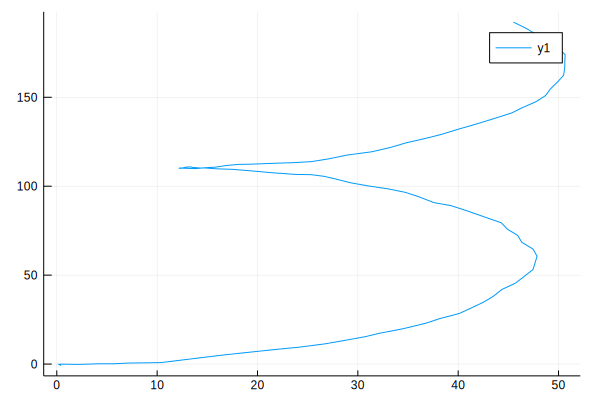

In [7]:
x = [x[1] for x in sim_states]
y = [x[3] for x in sim_states]
plot(x, y)

With position state estimates:

Remember, this is localizing position using only noisy velocity measurements.

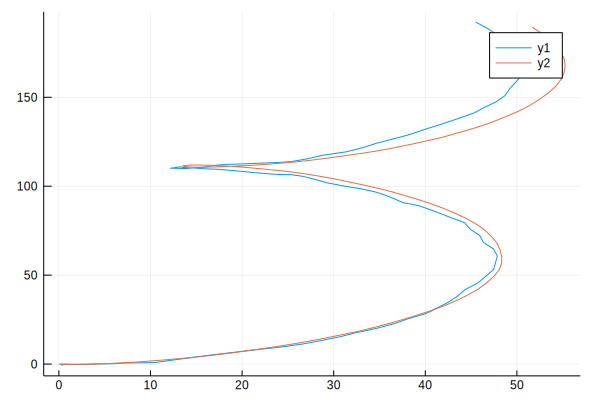

In [8]:
plot!(μ[:,1], μ[:,2])

Now using utilities to visualize 2D belief ellipse (95\% confidence bound by default) every 20th step.

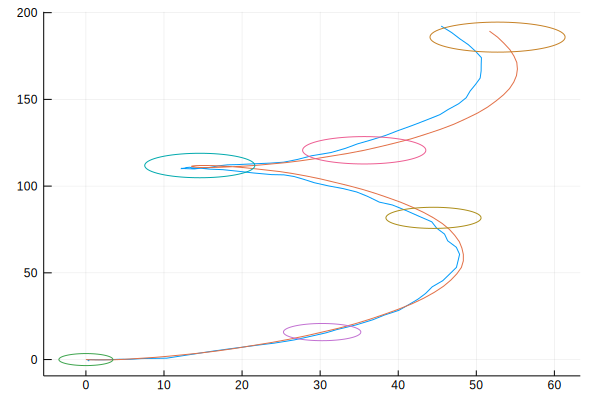

In [9]:
for i in 1:20:size(μ,1)
    x,y = belief_ellipse(μ[i,:], Σ[i,:,:])
    plot!(x,y)
end
plot!(legend=false)

True velocity

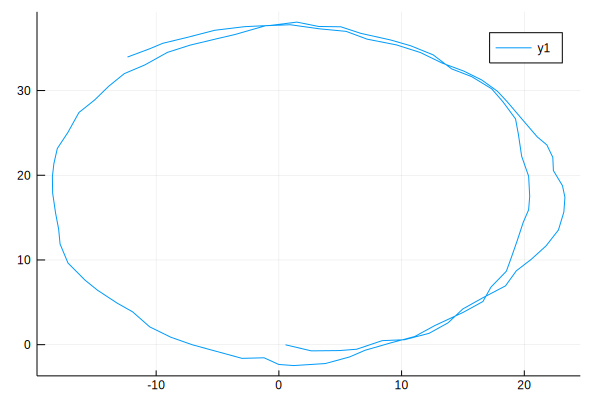

In [10]:
vx = [x[2] for x in sim_states]
vy = [x[4] for x in sim_states]
plot(vx, vy)